Human in the loop

In [1]:
import os
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F3F7F6EE70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F3F8078F20>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [15]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool # custom tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # reducers
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt # forcefully interrupting so human can provide feedback

ModuleNotFoundError: No module named 'langchain_community'

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)



In [10]:
@tool
def human_assistance(query: str) -> str:
    """requst assistance from a human"""
    human_response = interrupt({"query": query})
    return human_response["data"]




C:\Users\DELL\AppData\Local\Temp\ipykernel_5920\3327268755.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  @tool


ValidationError: 1 validation error for TavilySearchInput
  Input should be a valid dictionary or instance of TavilySearchInput [type=model_type, input_value=<function human_assistance at 0x000001F3FB6E0C20>, input_type=function]
    For further information visit https://errors.pydantic.dev/2.11/v/model_type

In [11]:
tool = TavilySearch(max_results=2)

tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # we will be interrupting during tool execution
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume

    return {"messages": [message]}

graph_builder.add_node("Chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "Chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "Chatbot")
graph_builder.add_edge(START, "Chatbot")



Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `Chatbot` already present.

In [12]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

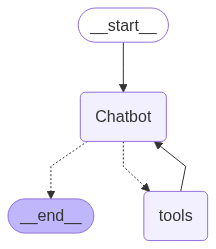

In [13]:
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [14]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
 

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (es1v5mpjp)
 Call ID: es1v5mpjp
  Args:
    query: expert guidance and assistance for building an AI agent
    search_depth: advanced
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "expert guidance and assistance for building an AI agent", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://cdn.openai.com/business-guides-and-resources/a-practical-guide-to-building-agents.pdf", "title": "[PDF] A practical guide to building agents - OpenAI", "content": "The path to successful deployment isn’t all-or-nothing. Start small, validate with real users, and grow ca